# Binary Classification of NSL-KDD Dataset

In [1]:
# For getting paths
import os

# For data manipulation and preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

# For feature engineering
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# For model building
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For model evaluation
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, classification_report

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For timing
import time

# Tensorflow and Keras
import tensorflow as tf
import time

## Dataset Visualization and Preprocessing

In [13]:
# Column Labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

# Datasets
train_path = "../datasets/nsl-kdd/KDDTrain+.txt"
test_path = "../datasets/nsl-kdd/KDDTest+.txt"

df_train=pd.read_csv(train_path,header=None,names=columns)
df_test=pd.read_csv(test_path,header=None,names=columns)

In [14]:
# Training Set Preview
print(df_train.shape)
print("--------------------")
print(df_train.head())
print("--------------------")
print(df_train.info())

(125973, 43)
--------------------
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60             

In [15]:
# Testing Set Preview
print(df_test.shape)
print("--------------------")
print(df_test.head())
print("--------------------")
print(df_test.info())

(22544, 43)
--------------------
   duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         0           tcp   private   REJ          0          0     0   
1         0           tcp   private   REJ          0          0     0   
2         2           tcp  ftp_data    SF      12983          0     0   
3         0          icmp     eco_i    SF         20          0     0   
4         1           tcp    telnet  RSTO          0         15     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.04   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.61   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    0.31   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.06                         0.00   
1                    0.06        

In [16]:
# Check for duplicates
print("Duplicates in Train: ", df_train.duplicated().sum())
print("Duplicates in Test: ", df_test.duplicated().sum())

# Check for missing values
print("-----------------------------------")
print("Rows with missing values - train: ", df_train.isnull().sum())
print("-----------------------------------")
print("Rows with missing values - test: ", df_test.isnull().sum())

Duplicates in Train:  0
Duplicates in Test:  0
-----------------------------------
Rows with missing values - train:  duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate             

In [17]:
df_train_binary = df_train.copy()

df_train_binary['attack'] = df_train_binary['attack'].apply(
    lambda x: 'attack' if x != 'normal' else 'normal'
)

df_test_binary = df_test.copy()

df_test_binary['attack'] = df_test_binary['attack'].apply(
    lambda x: 'attack' if x != 'normal' else 'normal'
)

In [18]:
# Helper function to plot bar labels
def add_bar_labels(bars):
    # Add counts on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height}',
            ha='center',
            va='bottom'
        )

In [19]:
# Binary encoding for 'attack' column
le_attack = LabelEncoder()
df_train_binary['attack'] = le_attack.fit_transform(df_train_binary['attack'])
df_test_binary['attack'] = df_test_binary['attack'].apply(lambda x: le_attack.transform([x])[0] if x in le_attack.classes_ else -1)

# Encode other categorical features
columns_to_encode = ['protocol_type', 'service', 'flag']
label_map = {}

for column in columns_to_encode:
    le = LabelEncoder()
    le.fit(df_train_binary[column])
    df_train_binary[column] = le.transform(df_train_binary[column])
    df_test_binary[column] = df_test_binary[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    label_map[column] = dict(zip(le.classes_, le.transform(le.classes_)))

# Display the label map
for column, mapping in label_map.items():
    print(f"Mapping for {column}: {mapping}")

# Display encoded DataFrames
print("\nEncoded df_train:")
print(df_train_binary)

print("\nEncoded df_test:")
print(df_test_binary)

Mapping for protocol_type: {'icmp': 0, 'tcp': 1, 'udp': 2}
Mapping for service: {'IRC': 0, 'X11': 1, 'Z39_50': 2, 'aol': 3, 'auth': 4, 'bgp': 5, 'courier': 6, 'csnet_ns': 7, 'ctf': 8, 'daytime': 9, 'discard': 10, 'domain': 11, 'domain_u': 12, 'echo': 13, 'eco_i': 14, 'ecr_i': 15, 'efs': 16, 'exec': 17, 'finger': 18, 'ftp': 19, 'ftp_data': 20, 'gopher': 21, 'harvest': 22, 'hostnames': 23, 'http': 24, 'http_2784': 25, 'http_443': 26, 'http_8001': 27, 'imap4': 28, 'iso_tsap': 29, 'klogin': 30, 'kshell': 31, 'ldap': 32, 'link': 33, 'login': 34, 'mtp': 35, 'name': 36, 'netbios_dgm': 37, 'netbios_ns': 38, 'netbios_ssn': 39, 'netstat': 40, 'nnsp': 41, 'nntp': 42, 'ntp_u': 43, 'other': 44, 'pm_dump': 45, 'pop_2': 46, 'pop_3': 47, 'printer': 48, 'private': 49, 'red_i': 50, 'remote_job': 51, 'rje': 52, 'shell': 53, 'smtp': 54, 'sql_net': 55, 'ssh': 56, 'sunrpc': 57, 'supdup': 58, 'systat': 59, 'telnet': 60, 'tftp_u': 61, 'tim_i': 62, 'time': 63, 'urh_i': 64, 'urp_i': 65, 'uucp': 66, 'uucp_path':

In [20]:
# "land," since this would have to be a check to see if src ip = dest ip
non_directly_obtainable_features = [
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'land',
    'level',   
]

X_train = df_train_binary.drop(non_directly_obtainable_features, axis=1)
X_test = df_test_binary.drop(non_directly_obtainable_features, axis=1)

In [21]:
# Split the data into features (x) and target (y) - Level is unknown in real-time
X_train = X_train.drop('attack', axis=1)
y_train = df_train_binary['attack']
X_test = X_test.drop('attack', axis=1)
y_test = df_test_binary['attack']

In [22]:
# Ratio of Training to Testing Data
# Step 1: Determine the sizes of training and test sets
train_size = len(df_train_binary)
test_size = len(df_test_binary)

# Step 2: Calculate the total number of samples
total_size = train_size + test_size

# Step 3: Calculate the ratios
train_ratio = train_size / total_size
test_ratio = test_size / total_size

print(f"Train ratio: {train_ratio:.2f}")
print(f"Test ratio: {test_ratio:.2f}")


Train ratio: 0.85
Test ratio: 0.15


### Feature Engineering

In [23]:
# SelectKBest for Top 20 Features
top_20_features = SelectKBest(mutual_info_classif, k=20)
top_20_features.fit(X_train, y_train)
X_train.columns[top_20_features.get_support()]

Index(['service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'srv_count',
       'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')

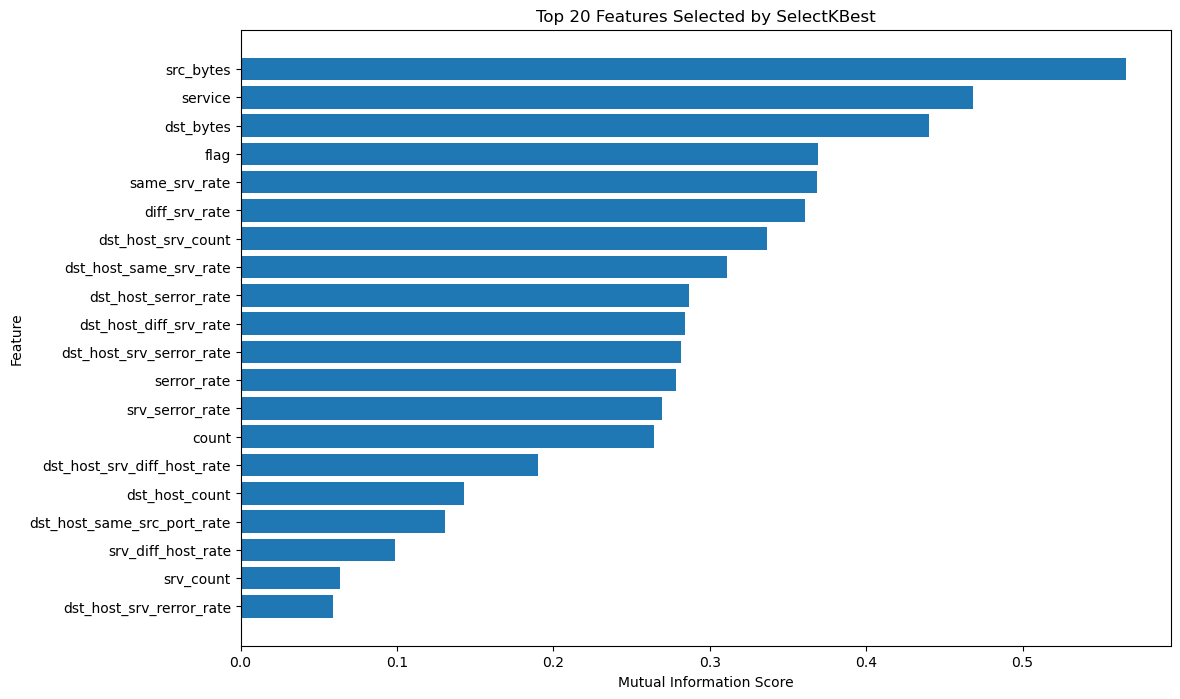

In [24]:
# Get the mask for the selected features
mask = top_20_features.get_support()

# Get the feature scores
feature_scores = top_20_features.scores_

# Get the selected feature names
selected_features = X_train.columns[mask]
selected_scores = feature_scores[mask]

# Create a DataFrame for plotting
df_top_features = pd.DataFrame({
    'Feature': selected_features,
    'Score': selected_scores
})

# Sort the DataFrame by scores in descending order
df_top_features = df_top_features.sort_values(by='Score', ascending=False)

# Plot the top features
plt.figure(figsize=(12, 8))
plt.barh(df_top_features['Feature'], df_top_features['Score'])
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Top 20 Features Selected by SelectKBest')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score on top
plt.show()


In [25]:
top_20_features = ['service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'srv_count',
       'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_srv_rerror_rate']

X_train = X_train[top_20_features]
X_test = X_test[top_20_features]

### Scale Data

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
sampled = False

## ML Results

In [27]:
# Create the classifiers
models = {
    "XGBoost": XGBClassifier(
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Decision Tree": DecisionTreeClassifier(),
}


# Train and evaluate each model
results = {}

for name, model in models.items():
    # Train the model
    start_train_time = time.time()
    model.fit(X_train, y_train)
    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # Predict on the test set
    start_pred_time = time.time()
    y_pred = model.predict(X_test)
    end_pred_time = time.time()
    pred_time = end_pred_time - start_pred_time

    # Decode labels for evaluation
    y_test_decoded = le.inverse_transform(y_test)
    y_pred_decoded = le.inverse_transform(y_pred)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
    precision = precision_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
    recall = recall_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
    f1 = f1_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
    conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)
    class_report = classification_report(y_test_decoded, y_pred_decoded, zero_division=1)

    # Store the results
    results[name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "conf_matrix": conf_matrix,
        "class_report": class_report,
        "train_time": train_time,
        "pred_time": pred_time
    }

    # Print evaluation metrics
    print(f'--- {name} ---')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f'Classification Report:\n{class_report}')
    print(f'Training Time: {train_time} seconds')
    print(f'Prediction Time: {pred_time} seconds')


--- XGBoost ---
Accuracy: 0.7848207948899929
Precision: 0.8204260308362883
Recall: 0.8075003500807081
F1 Score: 0.7842386575269956
Confusion Matrix:
[[8261 4572]
 [ 279 9432]]
Classification Report:
              precision    recall  f1-score   support

         OTH       0.97      0.64      0.77     12833
         REJ       0.67      0.97      0.80      9711

    accuracy                           0.78     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.78      0.78     22544

Training Time: 0.39311695098876953 seconds
Prediction Time: 0.00466609001159668 seconds
--- Logistic Regression ---
Accuracy: 0.7494233498935415
Precision: 0.7837209518630275
Recall: 0.7716988753355838
F1 Score: 0.7486909854143766
Confusion Matrix:
[[7839 4994]
 [ 655 9056]]
Classification Report:
              precision    recall  f1-score   support

         OTH       0.92      0.61      0.74     12833
         REJ       0.64      0.93      0.76      9711

    accurac

In [31]:
# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, model_name, le_attack):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le_attack.classes_, yticklabels=le_attack.classes_)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

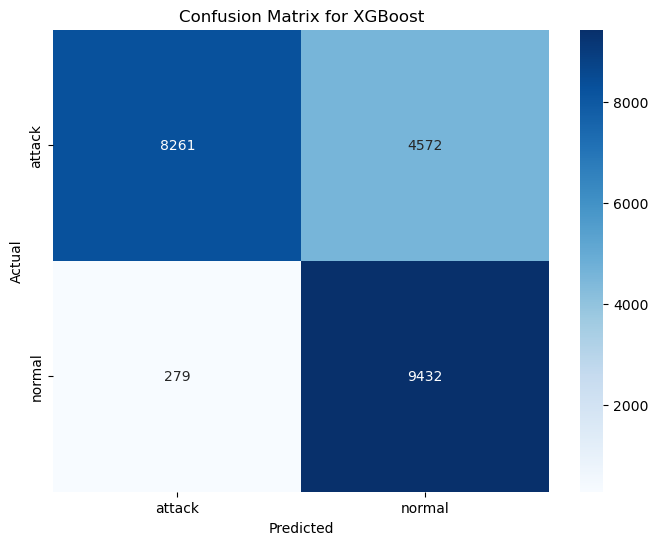

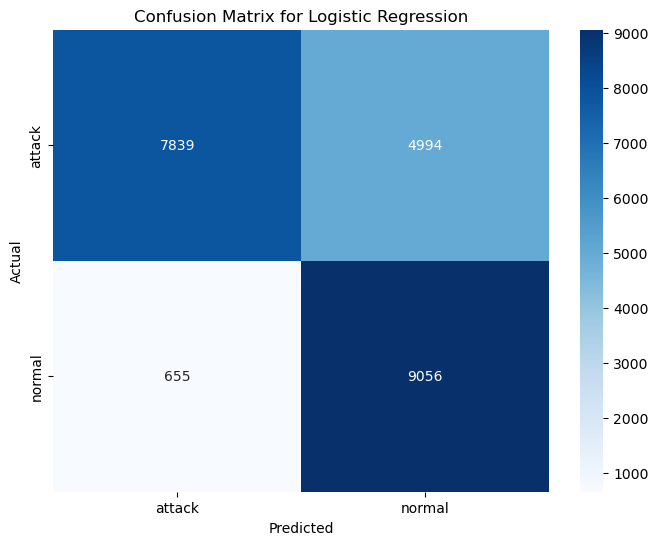

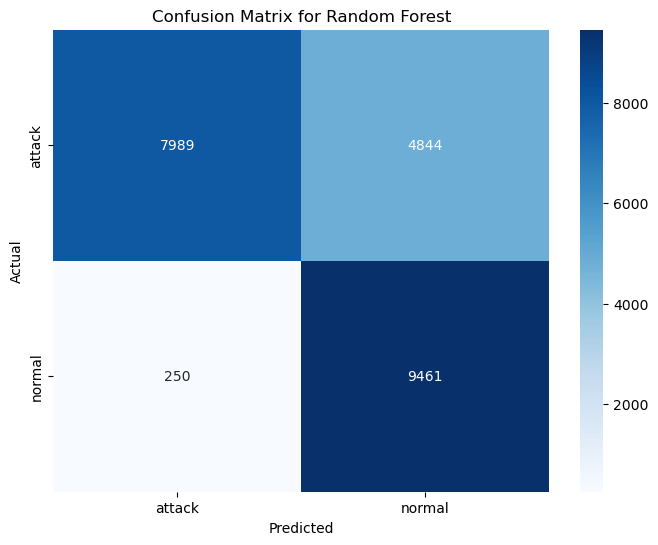

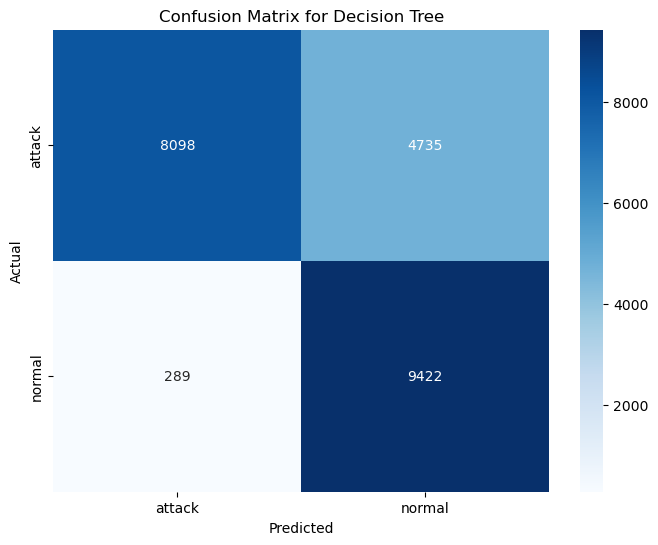

In [32]:
# Plot the confusion matrix for each model
for model_name, metrics in results.items():
    plot_confusion_matrix(metrics['conf_matrix'], model_name, le_attack)

In [30]:
# Print the mapping of labels
print("Label mapping for 'attack':")
for i, label in enumerate(le_attack.classes_):
    print(f"{i}: {label}")

Label mapping for 'attack':
0: attack
1: normal


## DL Results

In [46]:
def create_cnn_lstm_model(input_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=1))
    model.add(tf.keras.layers.LSTM(50))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # For binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [47]:
timesteps = 1
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], timesteps, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], timesteps, X_test.shape[1]))

input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
cnn_lstm_model = create_cnn_lstm_model(input_shape)
cnn_lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 1, 64)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,395 (95.29 KB)

 Trainable params: 24,395 (95.29 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Train the model
history = cnn_lstm_model.fit(X_train_reshaped, y_train, epochs=30, batch_size=64, validation_split=0.2)

# Evaluate the model
y_pred = cnn_lstm_model.predict(X_test_reshaped)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Decode labels for evaluation
y_test_decoded = le_attack.inverse_transform(y_test)
y_pred_decoded = le_attack.inverse_transform(y_pred_classes)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
precision = precision_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
recall = recall_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
f1 = f1_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)
class_report = classification_report(y_test_decoded, y_pred_decoded, zero_division=1)

Epoch 1/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 969us/step - accuracy: 0.9938 - loss: 0.0163 - val_accuracy: 0.9914 - val_loss: 0.0221
Epoch 2/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.9938 - loss: 0.0158 - val_accuracy: 0.9931 - val_loss: 0.0207
Epoch 3/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step - accuracy: 0.9937 - loss: 0.0167 - val_accuracy: 0.9942 - val_loss: 0.0185
Epoch 4/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - accuracy: 0.9942 - loss: 0.0148 - val_accuracy: 0.9914 - val_loss: 0.0226
Epoch 5/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step - accuracy: 0.9947 - loss: 0.0142 - val_accuracy: 0.9938 - val_loss: 0.0201
Epoch 6/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step - accuracy: 0.9943 - loss: 0.0145 - val_accuracy: 0.9930 - val_loss: 0.0204
Epoch 7/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - accuracy: 0.9949 - loss: 0.0133 - val_accuracy: 0.9932 - val_loss: 0.0206
Epoch 8/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - accuracy: 0.9946 -

In [54]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

Accuracy: 0.7794978708303761
Precision: 0.8194127951742278
Recall: 0.8034136237248695
F1 Score: 0.7786624743409328
Confusion Matrix:
[[8094 4739]
 [ 232 9479]]
Classification Report:
              precision    recall  f1-score   support

      attack       0.97      0.63      0.77     12833
      normal       0.67      0.98      0.79      9711

    accuracy                           0.78     22544
   macro avg       0.82      0.80      0.78     22544
weighted avg       0.84      0.78      0.78     22544



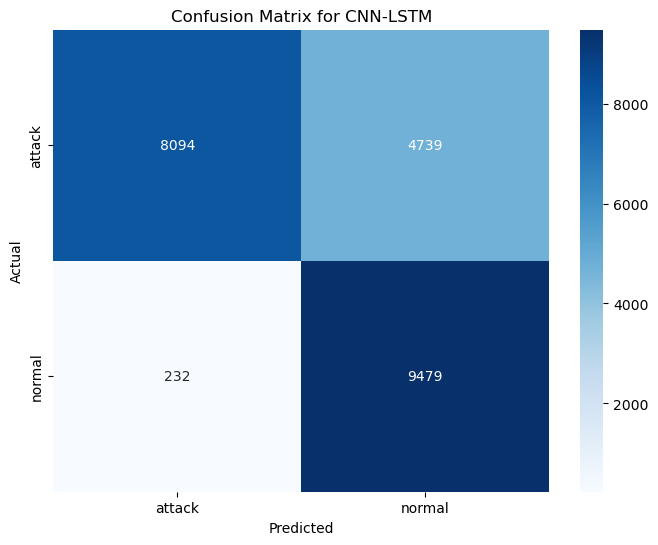

In [55]:
# Plot confusion matrix
plot_confusion_matrix(conf_matrix, 'CNN-LSTM', le_attack)

In [1]:
def create_cnn_model(input_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=1))
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=1))
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # For binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [59]:
# Assuming X_train and X_test are your feature sets
timesteps = 1
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], timesteps, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], timesteps, X_test.shape[1]))

input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
cnn_model = create_cnn_model(input_shape)
cnn_model.summary()

# Train the model
cnn_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=64, validation_split=0.2)

# Evaluate the model
y_pred = cnn_model.predict(X_test_reshaped)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Decode labels for evaluation
y_test_decoded = le_attack.inverse_transform(y_test)
y_pred_decoded = le_attack.inverse_transform(y_pred_classes)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
precision = precision_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
recall = recall_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
f1 = f1_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)
class_report = classification_report(y_test_decoded, y_pred_decoded, zero_division=1)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1, 64)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,645 (18.14 KB)

 Trainable params: 4,645 (18.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step - accuracy: 0.9560 - loss: 0.1423 - val_accuracy: 0.9798 - val_loss: 0.0607
Epoch 2/20
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.9788 - loss: 0.0587 - val_accuracy: 0.9831 - val_loss: 0.0485
Epoch 3/20
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.9832 - loss: 0.0455 - val_accuracy: 0.9858 - val_loss: 0.0410
Epoch 4/20
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.9856 - loss: 0.0394 - val_accuracy: 0.9867 - val_loss: 0.0379
Epoch 5/20
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.9864 - loss: 0.0370 - val_accuracy: 0.9882 - val_loss: 0.0336
Epoch 6/20
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.9881 - loss: 0.0331 - val_accuracy: 0.9904 - val_loss: 0.0290
Epoch 7/20
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.9882 - loss: 0.0322 - val_accuracy: 0.9903 - val_loss: 0.0285
Epoch 8/20
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step - accuracy: 0.9898 -

In [60]:
# Print evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

Accuracy: 0.7737757274662882
Precision: 0.815780450602902
Recall: 0.7982747855797289
F1 Score: 0.7727751353217841
Confusion Matrix:
[[7974 4859]
 [ 241 9470]]
Classification Report:
              precision    recall  f1-score   support

      attack       0.97      0.62      0.76     12833
      normal       0.66      0.98      0.79      9711

    accuracy                           0.77     22544
   macro avg       0.82      0.80      0.77     22544
weighted avg       0.84      0.77      0.77     22544



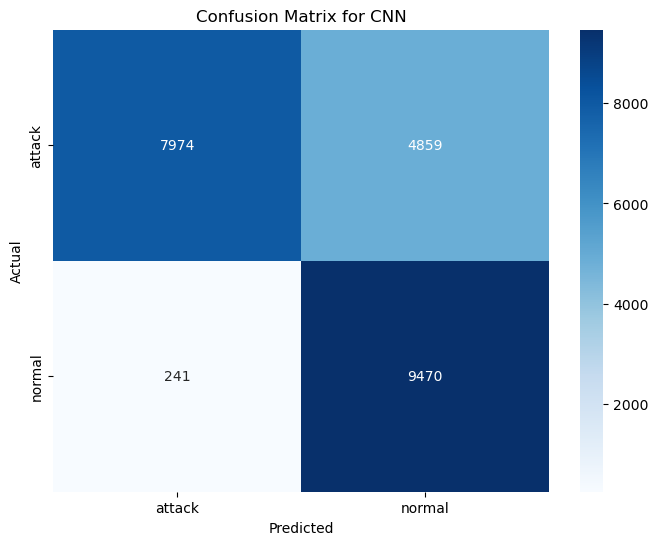

In [61]:
# Plot confusion matrix
plot_confusion_matrix(conf_matrix, 'CNN', le_attack)

In [63]:
import tensorflow as tf

# Define the Autoencoder
input_dim = X_train.shape[1]
latent_dim = 64  # Size of the latent space

# Encoder
inputs = tf.keras.layers.Input(shape=(input_dim,))
encoded = tf.keras.layers.Dense(128, activation='relu')(inputs)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(latent_dim, activation='relu')(encoded)

# Decoder
decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder Model
autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)  # Separate encoder model
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,164 (117.83 KB)

 Trainable params: 30,164 (117.83 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Filter the normal data for training the autoencoder
normal_label = le_attack.transform(['normal'])[0]
X_train_normal = X_train[y_train == normal_label]

# Train the autoencoder
autoencoder.fit(X_train_normal, X_train_normal, epochs=100, batch_size=16, validation_split=0.2)


Epoch 1/100
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 2s 584us/step - loss: 0.3267 - val_loss: 0.3244
Epoch 2/100
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 2s 572us/step - loss: 0.3275 - val_loss: 0.3243
Epoch 3/100
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 2s 575us/step - loss: 0.3266 - val_loss: 0.3205
Epoch 4/100
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 2s 568us/step - loss: 0.3210 - val_loss: 0.3204
Epoch 5/100
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 2s 568us/step - loss: 0.3215 - val_loss: 0.3204
Epoch 6/100
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 2s 570us/step - loss: 0.3217 - val_loss: 0.3213
Epoch 7/100
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 2s 563us/step - loss: 0.3226 - val_loss: 0.3204
Epoch 8/100
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 2s 569us/step - loss: 0.3219 - val_loss: 0.3204
Epoch 9/100
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 2s 565us/step - loss: 0.3207 - val_loss: 0.3207
Epoch 10/100
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 2s 573us/step - loss: 0.3199 - val_loss: 0.3203
Epoch 11/100
3368/3368 ━━━━━━━━━━━━━━━━━━━━ 2s 567us/step - loss: 0.3214 - val_loss: 0.32

In [68]:
# Calculate reconstruction error on the test set
reconstructions = autoencoder.predict(X_test)
reconstruction_error = tf.keras.losses.mse(X_test, reconstructions)

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 95)  # Example: 95th percentile
anomalies = reconstruction_error > threshold

# Decode labels for evaluation
y_test_decoded = le_attack.inverse_transform(y_test)
anomalies_decoded = ['attack' if x else 'normal' for x in anomalies]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_decoded, anomalies_decoded)
precision = precision_score(y_test_decoded, anomalies_decoded, pos_label='attack', average='binary', zero_division=1)
recall = recall_score(y_test_decoded, anomalies_decoded, pos_label='attack', average='binary', zero_division=1)
f1 = f1_score(y_test_decoded, anomalies_decoded, pos_label='attack', average='binary', zero_division=1)
conf_matrix = confusion_matrix(y_test_decoded, anomalies_decoded)
class_report = classification_report(y_test_decoded, anomalies_decoded, zero_division=1)

# Print evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
Accuracy: 0.46371540099361247
Precision: 0.8319928507596068
Recall: 0.07254733889191928
F1 Score: 0.13345756880733944
Confusion Matrix:
[[  931 11902]
 [  188  9523]]
Classification Report:
              precision    recall  f1-score   support

      attack       0.83      0.07      0.13     12833
      normal       0.44      0.98      0.61      9711

    accuracy                           0.46     22544
   macro avg       0.64      0.53      0.37     22544
weighted avg       0.67      0.46      0.34     22544



In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, 'Autoencoder')